**Testing Neural Network Tasks**

In [1]:
# Initial Imports
import pandas as pd
import json

In [3]:
# Load the 3D-Printing results JSON data
file_path = r"C:\Users\Jorwi\machine_learning\machine-learning\neural-networks\3D-Printing\printer_data_log.json"

In [5]:
# Read the file line by line and parse each JSON object
with open(file_path, "r") as file:
    data = [json.loads(line) for line in file if line.strip()]


- file is in **JSON Lines format**, each line is its own JSON object (not a single giant JSON array).

- `line.strip()` removes blank lines or lines with only whitespace, so we don’t try to parse them.

- `json.loads(line)` turns the line (a string) into a Python dictionary.

In [ ]:
# Converts list of nested dictionaries into a flat table (pandas DataFrame)
df = pd.json_normalize(data)

- JSON contains nested dictionaries (ex: `"printer"`, `"job"`)

- `json_normalize` flattens these, so keys like `printer.temp_bed` become columns

- This makes the data **usable for analysis or ML**.

In [ ]:
# Convert timestamps column from string to a datetime object
df["timestamp"] = pd.to_datetime(df["timestamp"])

- Pandas can’t perform time-based operations (sorting, time windows, plotting) **unless it knows** the column is a `datetime`.

- This allows you to do stuff like `df.set_index("timestamp")` or `resample()`.

- `df.set_index("timestamp")` changes your DataFrame so that the `timestamp` **becomes the row index**, not just a column. Common for time-series data to be indexed this way because it **simplifies processing**.
- `resample()` is a time-aware function that **groups data into fixed time intervals**. 


In [ ]:
# Sort by time in ascending order, and reset index so (0, 1, 2) so it's clean
df = df.sort_values("timestamp").reset_index(drop=True)

- logs might not be in exact time order.

- Time-series models (like LSTM), which are designed to handle data that changes over time, **require data to be chronologically ordered**.

- `reset_index(drop=True)` keeps things clean by removing the old, unsorted index.

In [9]:
df.head()

,timestamp,storage.path,storage.name,storage.read_only,printer.state,printer.temp_bed,printer.target_bed,printer.temp_nozzle,printer.target_nozzle,printer.axis_z,printer.axis_x,printer.axis_y,printer.flow,printer.speed,printer.fan_hotend,printer.fan_print,job.id,job.progress,job.time_remaining,job.time_printing
0,2025-02-26 09:58:09,/usb/,usb,False,IDLE,27.0,0.0,28.0,0.0,0.0,-1.0,-4.0,100,100,0,0,NaN,NaN,NaN,NaN
1,2025-02-26 09:58:14,/usb/,usb,False,IDLE,27.1,0.0,28.0,0.0,0.0,-1.0,-4.0,100,100,0,0,NaN,NaN,NaN,NaN
2,2025-02-26 09:58:19,/usb/,usb,False,IDLE,27.1,0.0,28.0,0.0,0.0,-1.0,-4.0,100,100,0,0,NaN,NaN,NaN,NaN
3,2025-02-26 09:58:24,/usb/,usb,False,IDLE,27.1,0.0,28.0,0.0,0.0,-1.0,-4.0,100,100,0,0,NaN,NaN,NaN,NaN
4,2025-02-26 10:04:29,/usb/,usb,False,PRINTING,27.6,60.0,38.5,170.0,0.0,NaN,NaN,100,100,0,0,86.0,0.0,12120.0,5.0


**Task 1: Predicting Nozzle Temperature in the Near Future**

This is a **regression task**, meaning we want a number not a label. Will use time-series modeling.

**What will be predicted:**
- `printer.temp_nozzle` 10 seconds into the future.

**Goal:**
- Given the recent data (temps, fan speeds, Z-height), predict what the nozzle temperature will be in 10 seconds.

**Step 1:** Preprocessing

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
# Parameters
window_size = 5     # How many past time steps will be used as input for each prediction, allowing the model to lean short-term trends in the data.
step_ahead = 1      # How far in the future to predict

In [23]:
# Select meaningful input features that may influence nozzle temperature
features = [
    "printer.temp_bed", "printer.target_bed", "printer.temp_nozzle",
    "printer.target_nozzle", "printer.axis_z", 
    "printer.fan_hotend", "printer.fan_print"
]

In [14]:
# Filter the relevant data and drop NaNs
df_filtered = df[features].fillna(method="ffill").fillna(method="bfill")

C:\Users\Jorwi\AppData\Local\Temp\ipykernel_47492\3317640601.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df[features].fillna(method="ffill").fillna(method="bfill")


Selects only the chosen features from full DataFrame, filling in missing values using
- `forward-fill (ffill)` which copies the last known value forward
- `backward-fill ()` which copies the next known value backwards as backup

In [17]:
# Normalize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_filtered)

Standardizes the data so each feature has **Mean = 0**, **Standard deviation = 1**, which helps the NN train faster and more accurately as you bring all features onto the same scale.

In [ ]:
# Create sliding windows
X = []
y = []

# Loop that creates the training data
for i in range(window_size, len(data_scaled) - step_ahead):
    X_window = data_scaled[i - window_size:i]   # Sequence of N steps
    y_target = data_scaled[i + step_ahead][features.index("printer.temp_nozzle")]   # Predict future nozzle temp
    X.append(X_window)
    y.append(y_target)

- Each `X_window` is a sequence of past sensor readings over `window_size` time steps, helping the model recognize short-term trends. 
- The corresponding `y_target` is the nozzle temperature that occurs `step_ahead` steps after the window ends.
- Together, they form training pairs that teach the model to predict future temperatures based on recent patterns.

In [ ]:
# Convert lists to NumPy arrays for use in TensorFlow/Keras models.
X = np.array(X)
y = np.array(y)

In [ ]:
print("Input shape (x):", X.shape)

Input shape (x): (8704, 5, 7)


- displays the `num_samples`, `window_size`, and `num_features`. 

In [21]:
print("Target shape (y):", y.shape)

Target shape (y): (8704,)


- displays the `num_samples`.
- has shape `(num_samples,)` because each training example predicts a **single future nozzle temp**, not a sequence or multiple number of outputs

Now ready to feed into a Neural Network.

**Step 2:** Build a **LSTM** Neural Network

**Goal of the model is to:**
- Take in sequences of past printer data (`X`)
- Learn to predict the future nozzle temperature (`y`)
- Be evaluated using Mean Squared Error (MSE).

**What are LSTMs?**

*LSTMs (Long Short-Term Memory Networks)* are a specialized type of *Recurrent Neural Network (RNN)* designed to handle **sequential data** like time-series, text or audio. Unlike traditional neural networks which treat each input independently, LSTMs can **remember patters over time**, which is ideal for learning from temporal relationships in data, which refer to the **order and timing of events** in a sequence.

An LSTM is typically used in architectures like `Input -> LSTM -> Dense -> Output`, or in deeper models with multiple stacked LSTM layers.

**Why use an LSTM here?**

We're working with 3D printer data that changes over time like temperature, fan speed and axis movement. Since future data collected may also be sequential (ex: print behaviors, sensor streams), LSTmMs are a good fit. They combine the **learning power of deep neural networks** with the ability to **capture time-based dependencies**, making them well suited for time-series prediction tasks like predicting nozzle temperature. 

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [26]:
# Define LSTM Model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

c:\Users\Jorwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- `Sequential([...])`: Defines a simple linear stack of layers where data flows from input to output.

- `LSTM(64, ...)`:
    - This is the **main LSTM layer** with 64 units, which means it learns 64 different patterns (or sequences) from the input.
    - `activation='tanh'` is the default activation function for LSTMs, helping it handle both positive and negative signal values.
    - `input_shape=(X.shape[1], X.shape[2])` tells the model the shape of each training example:
        - `X.shape[1]`: number of time steps (your window_size)
        - `X.shape[2]`: number of features per time step (temp, fan speed, etc.)

- `Dense(32, activation='relu')`:
    - A fully connected (dense) layer with 32 neurons.
    - It applies the **ReLU activation function** to introduce non-linearity, helping the model learn more complex patterns from the LSTM output.

- `Dense(1)`:
    - The final output layer with a **single neuron** to predict one value: the future nozzle temperature.
    - No activation function is used here because this is a regression task, so we want a raw number.

In [27]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

- `optimizer=Adam`: A popular optimizer that adjusts weights efficiently using adaptive learning rates. It's great for deep learning and handles noisy gradients well.
- `loss='mse'`: Mean Squared Error is the primary metric for regression tasks as it penalizes larger errors more heavily.
- `metrics=['mae']`: Adds Mean Absolute Error as a secondary metric, which is easier to interpret (average absolute difference between predicted and actual values).

In [28]:
history = model.fit(
    X, y,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1768 - mae: 0.2046 - val_loss: 0.0143 - val_mae: 0.0690
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0608 - mae: 0.0834 - val_loss: 0.0069 - val_mae: 0.0571
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - mae: 0.0491 - val_loss: 0.0076 - val_mae: 0.0536
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - mae: 0.0553 - val_loss: 0.0050 - val_mae: 0.0483
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - mae: 0.0569 - val_loss: 0.0063 - val_mae: 0.0525
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0472 - mae: 0.0718 - val_loss: 0.0042 - val_mae: 0.0432
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0175 - mae: 0.0456 - val_loss: 0.0045 - val_mae: 0.0508
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - mae: 0.0394 - val_loss: 0.0043 - val_mae: 0.0447
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

- `X, y`: The training data (inputs and targets).
- `epochs=20`: The model will go through the entire dataset 20 times to learn.
- `batch_size=32`: The model updates weights after every 32 samples (mini-batch training).
- `validation_split=0.2`: 20% of the data is used for validation during training to monitor generalization.
- `shuffle=False`: Important for time-series tasks— as it keeps the order of sequences so temporal relationships are preserved.

**Step 3: Visualizations and Relationships**

In [ ]:
import matplotlib.pyplot as plt

First we'll look at the **Training and Validation Loss Over Epochs** which helps us see how well the model learned and if it's overfitting.

In [30]:
# Plot loss and mean absolute error over training
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

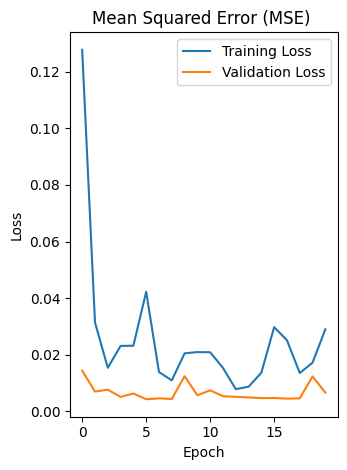

In [35]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Mean Squared Error (MSE) ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

- If the `Training Loss (blue)` starts high and drops quickly then it shows the model is learning early on.
- If the `Validation Loss (orange)` stays low and stable it indicates the model is **not overfitting**, meaning it generalizes well to unseen data and isn't memorizing.
- Fluctuations in training loss are normal for time-series models, especially with small batch sizes and noisy real-world data.

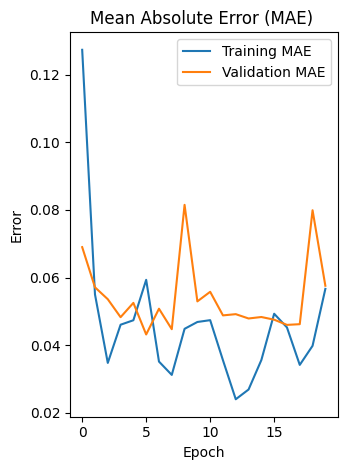

In [36]:
# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) ')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

- The `Mean Absolute Error (MAE)` gives an intuitive sense of how far off the predictions are on average, as it tells you the **average size of prediction errors**.
- If the model stays around the lower middle (.04-.08) on `validation (orange)` that is quite reasonable. 
- If there is some fluctuation, but the `validation (orange)` and `training (blue)` are close, then this supports **good generalization**.

Now we'll plot **Predictions vs Actual Nozzle Temperatures** which will compare model predictions to real values on a subset of the data. 

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


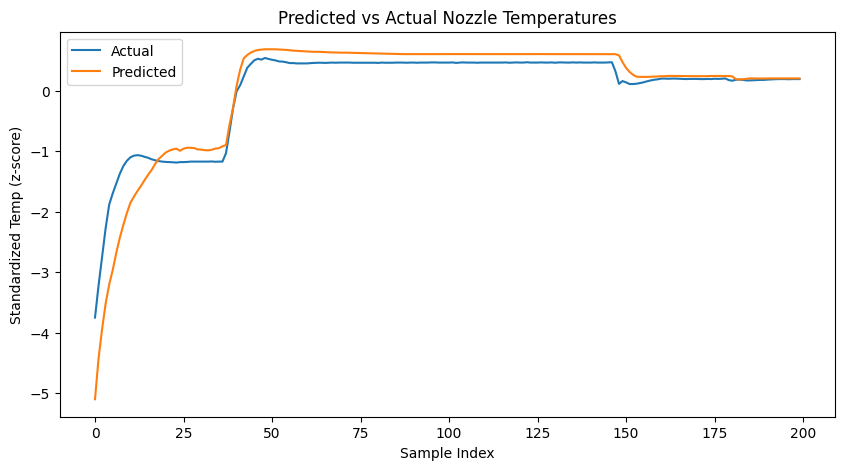

In [37]:
# Use model to predict on all data (could also be split into test only)
predictions = model.predict(X)

# Plot a sample of predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y[:200], label='Actual')
plt.plot(predictions[:200], label='Predicted')
plt.title('Predicted vs Actual Nozzle Temperatures')
plt.xlabel('Sample Index')
plt.ylabel('Standardized Temp (z-score)')
plt.legend()
plt.show()

- `The blue Line` represents the **actual standardized nozzle temperatures**, the `orange line` shows the **model's predicted values**.
- If the predicted curve closely follows the actual one, especially where temperature changes sharply, then it shows **the model is capturing the overall trend** and reacting correctly to dynamic shifts.
- Minor deviations are expected, especially with real-world sensor data.

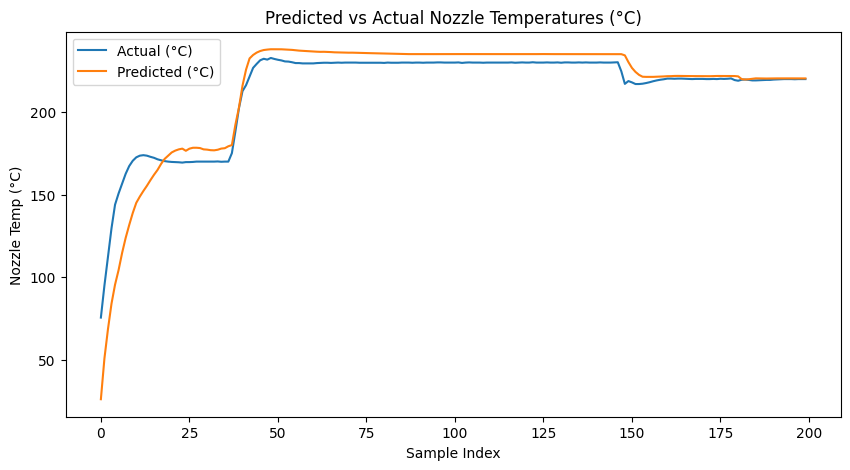

In [ ]:
# Get only the "printer.temp_nozzle" column (index used earlier)
nozzle_index = features.index("printer.temp_nozzle")

# Create a placeholder array for inverse_transform (matching original # of features)
pred_full = np.zeros((len(predictions), len(features)))
actual_full = np.zeros((len(y), len(features)))

# Inserts predictions/targets into only one column: Fill only the temp_nozzle column
pred_full[:, nozzle_index] = predictions[:, 0]
actual_full[:, nozzle_index] = y

# Inverse transform back to Celsius
pred_celsius = scaler.inverse_transform(pred_full)[:, nozzle_index]
actual_celsius = scaler.inverse_transform(actual_full)[:, nozzle_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(actual_celsius[:200], label='Actual (°C)')
plt.plot(pred_celsius[:200], label='Predicted (°C)')
plt.title('Predicted vs Actual Nozzle Temperatures (°C)')
plt.xlabel('Sample Index')
plt.ylabel('Nozzle Temp (°C)')
plt.legend()
plt.show()